In [1]:
from IPython.display import Image

- references
    - https://medium.com/@vishnuvijayanpv/deep-reinforcement-learning-artificial-intelligence-machine-learning-and-deep-learning-e52cb5974420
    - https://openai.com/research/instruction-following

## basics


- `WithValueHead`
    - `AutoModelForCausalLMWithValueHead`
    ```
    (v_head): ValueHead(
        (dropout): Dropout(p=0.1, inplace=False)
        (summary): Linear(in_features=768, out_features=1, bias=True)
        (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    ```
- `reward model`


- loss
    - policy loss
    - value loss
    - entropy loss

```
def step(
    self,
    queries: List[torch.LongTensor],
    responses: List[torch.LongTensor],
    scores: List[torch.FloatTensor],
):
```

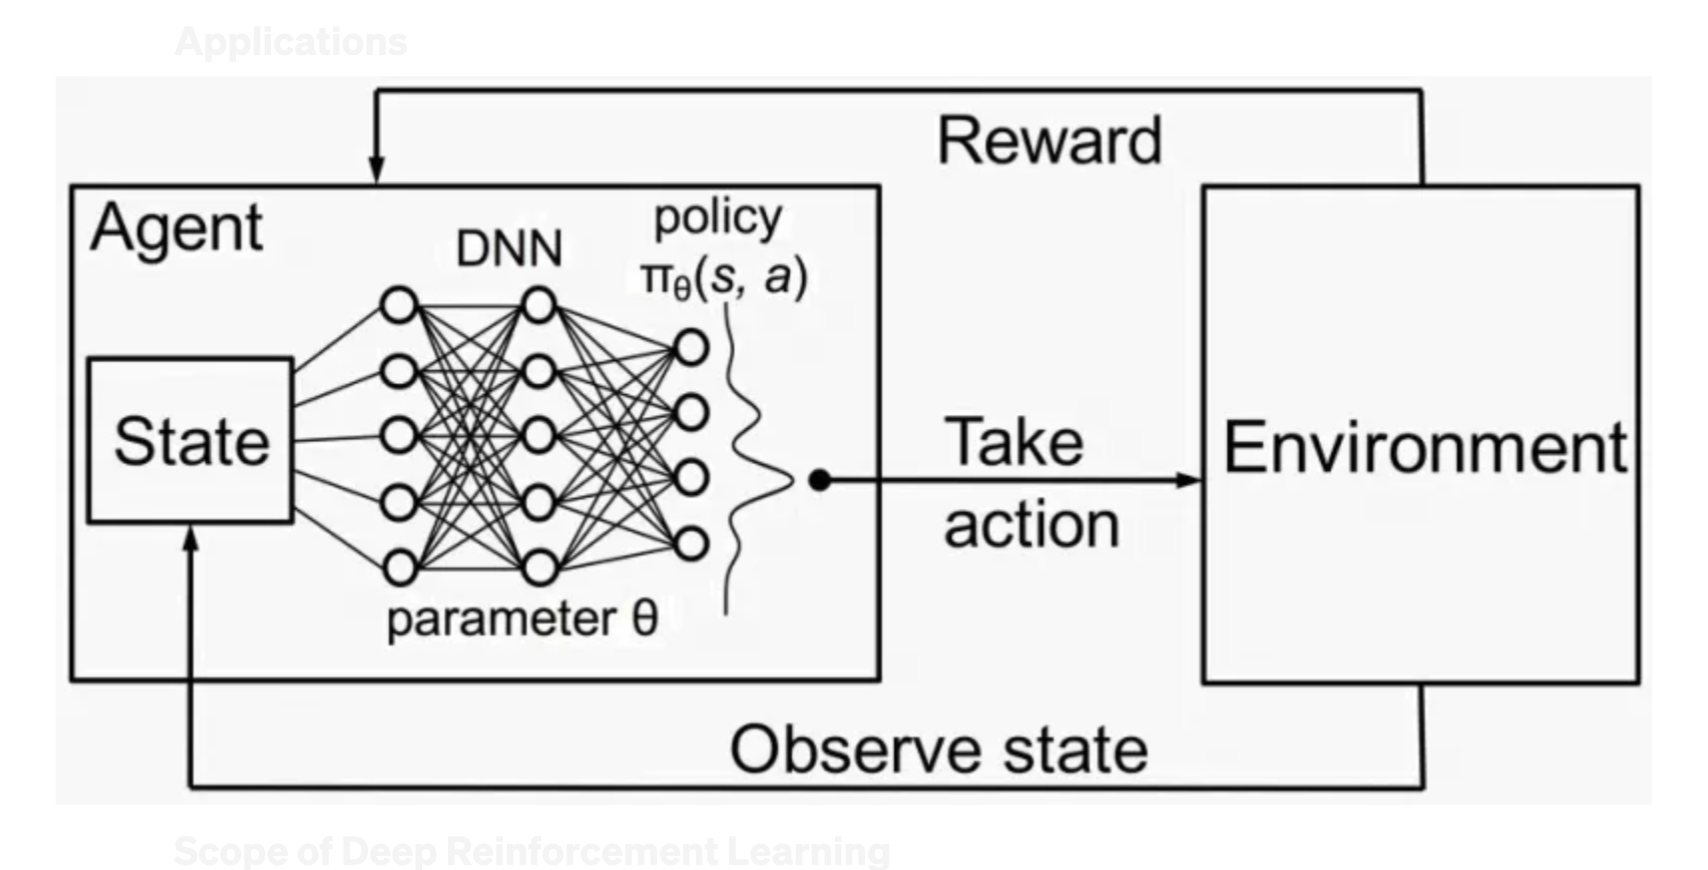

In [2]:
Image('../imgs/drl.png', width=400)

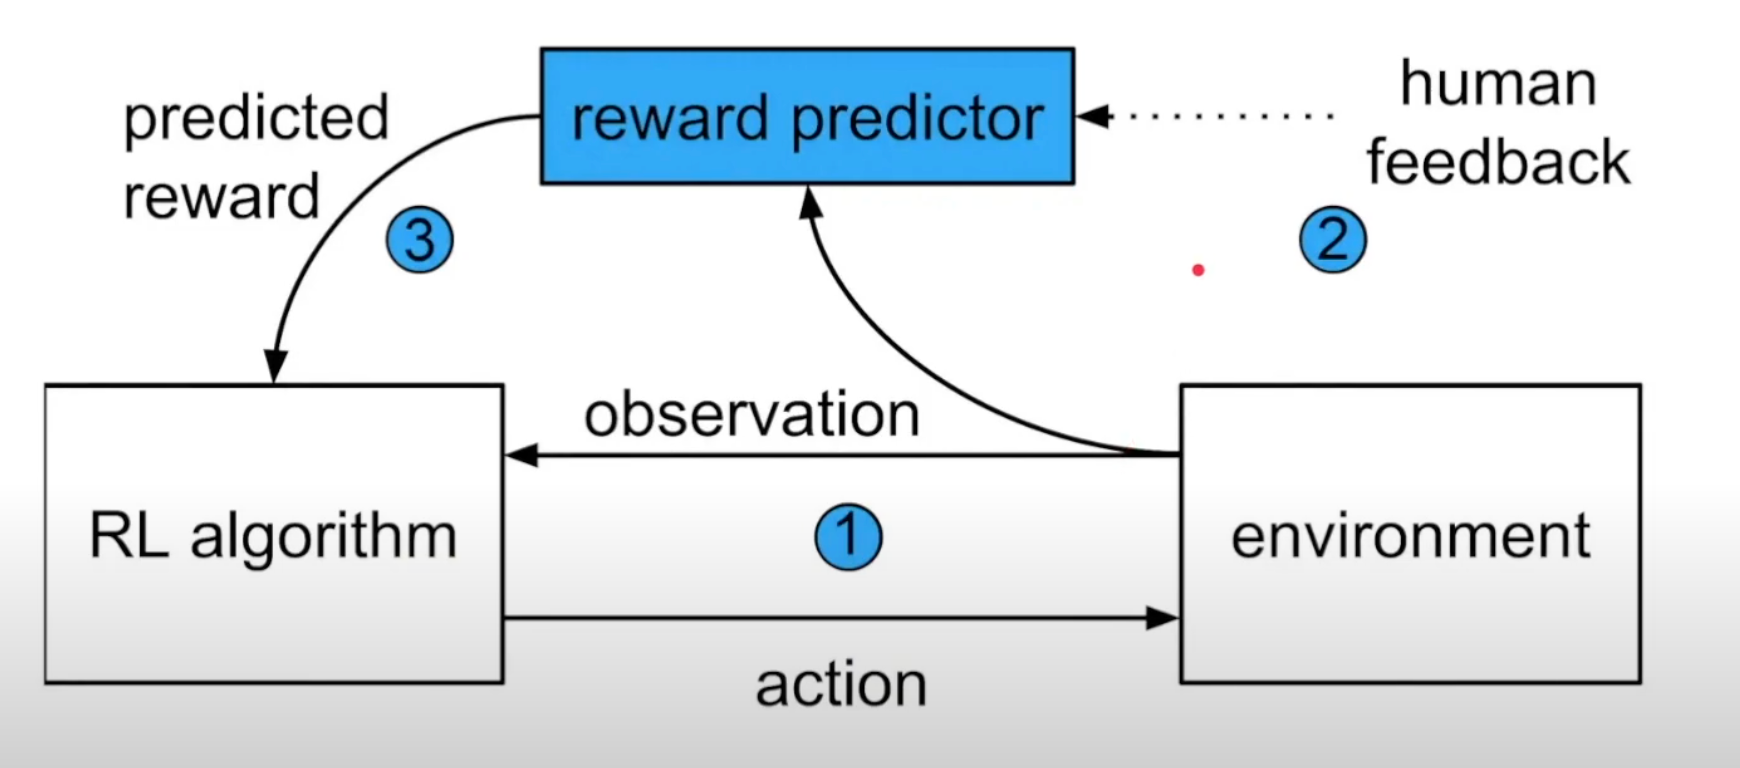

In [3]:
Image('../imgs/rlhf.png', width=400)

## 一个例子

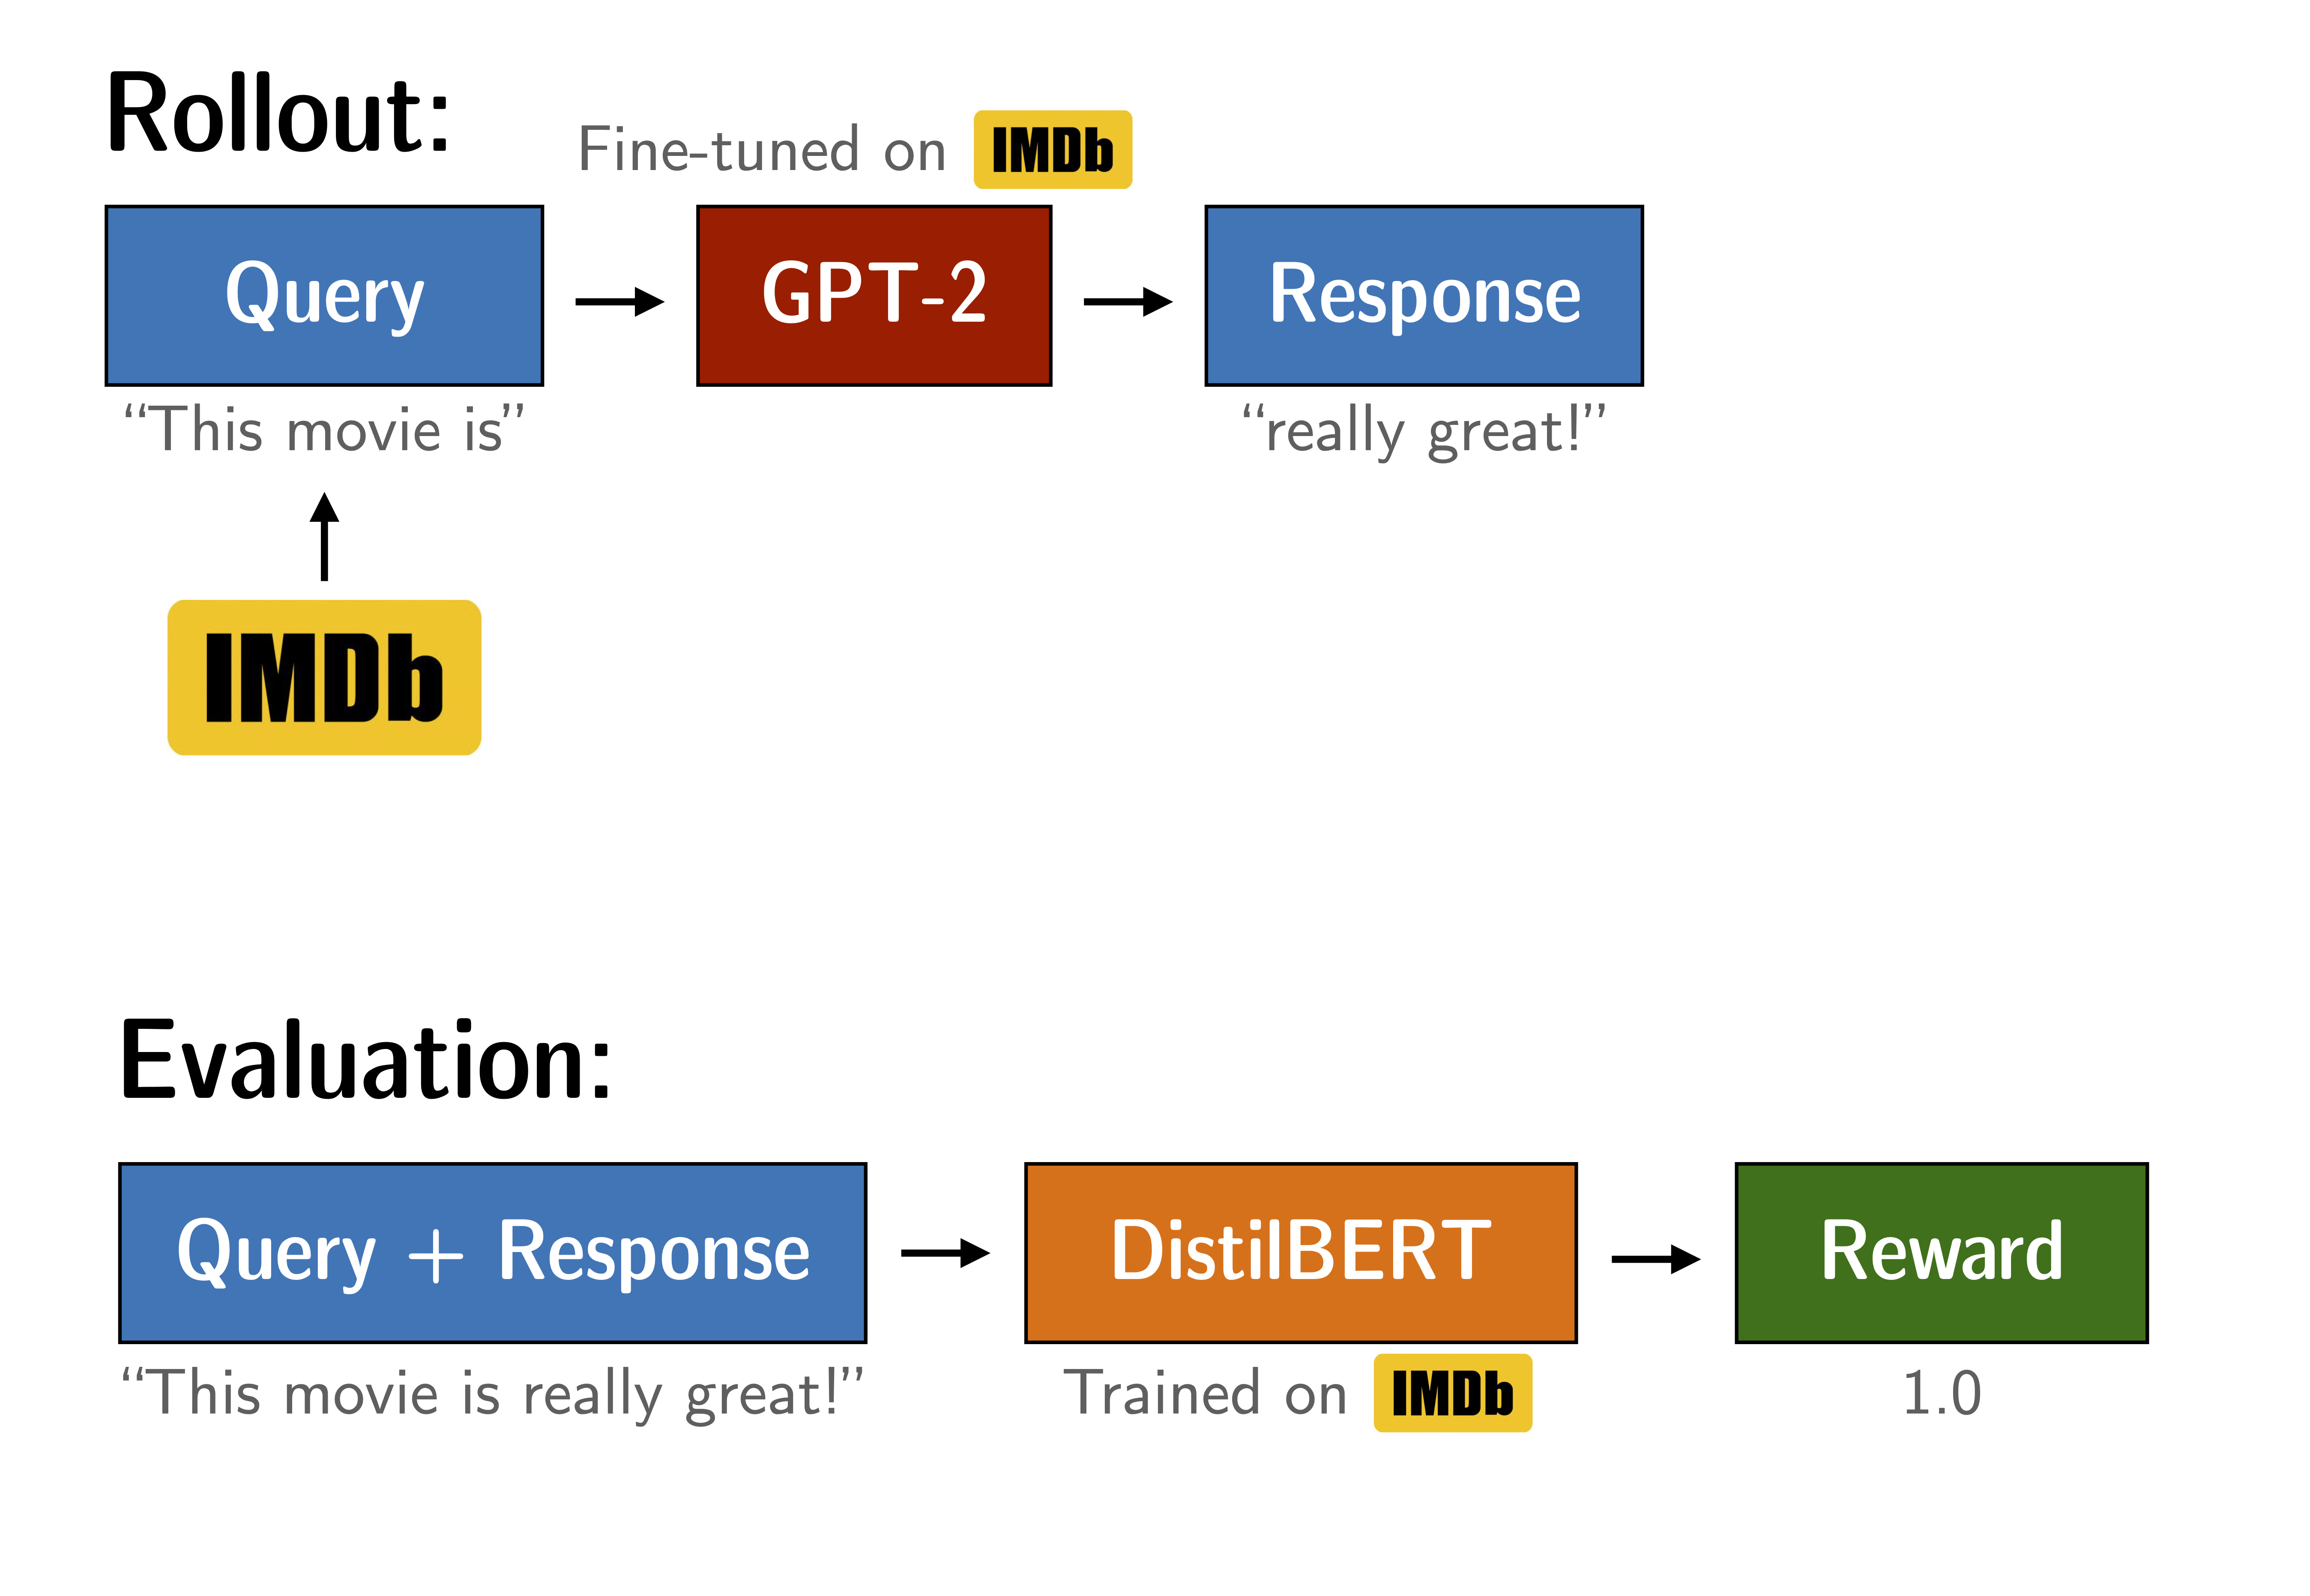

In [4]:
Image('../imgs/gpt2_bert_training.png', width=500)

- gpt-2 待 fine-tune 的生成 positive review 的生成式模型；
- distilbert 作为 reward model 去打分；

In [5]:
import torch
from tqdm import tqdm
import pandas as pd

# tqdm.pandas()

from transformers import pipeline, AutoTokenizer
from datasets import load_dataset

from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead
from trl.core import LengthSampler

In [6]:
config = PPOConfig(
    model_name="lvwerra/gpt2-imdb",
    learning_rate=1.41e-5,
    log_with="wandb",
)

sent_kwargs = {"return_all_scores": True, "function_to_apply": "none", "batch_size": 64}

fatal: No names found, cannot describe anything.


In [7]:
import wandb

wandb.init()

wandb: Currently logged in as: lanchunhui (loveresearch). Use `wandb login --relogin` to force relogin


### dataset

In [8]:
input_size = LengthSampler(2, 8)
input_size()

4

In [9]:
def build_dataset(config, dataset_name="imdb", input_min_text_length=2, input_max_text_length=8):
    tokenizer = AutoTokenizer.from_pretrained(config.model_name)
    tokenizer.pad_token = tokenizer.eos_token
    # load imdb with datasets
    ds = load_dataset(dataset_name, split="train")
    ds = ds.rename_columns({"text": "review"})
    ds = ds.filter(lambda x: len(x["review"]) > 200, batched=False)

    input_size = LengthSampler(input_min_text_length, input_max_text_length)

    def tokenize(sample):
        sample["input_ids"] = tokenizer.encode(sample["review"])[: input_size()]
        sample["query"] = tokenizer.decode(sample["input_ids"])
        return sample

    ds = ds.map(tokenize, batched=False)
    ds.set_format(type="torch")
    return ds


In [10]:
dataset = build_dataset(config)

def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

In [11]:
dataset

Dataset({
    features: ['review', 'label', 'input_ids', 'query'],
    num_rows: 24895
})

In [12]:
dataset['label']

tensor([0, 0, 0,  ..., 1, 1, 1])

In [13]:
dataset['query'][:10]

['I rented I AM',
 '"I Am Curious:',
 'If only to avoid making this type',
 'This film was probably inspired by',
 'Oh, brother...after hearing about',
 'I would put this at the',
 'Whoever wrote the',
 'When I first saw',
 'Who are these "They',
 'This is said to be a']

### models

- model: 待对齐reward model，也即待 finetune model
- ref_model：作为 fine tune 的基线值，希望不偏离原始 model 太多，不 fine-tune
    - 初始时，model 与 ref_model 是一致的；
- reward model：score model，
    - fine-tune 好了的 model

In [14]:
model =     AutoModelForCausalLMWithValueHead.from_pretrained(config.model_name)
ref_model = AutoModelForCausalLMWithValueHead.from_pretrained(config.model_name)

tokenizer = AutoTokenizer.from_pretrained(config.model_name)
tokenizer.pad_token = tokenizer.eos_token

ppo_trainer = PPOTrainer(config, model, ref_model, tokenizer, dataset=dataset, data_collator=collator)

In [15]:
ppo_trainer.accelerator.num_processes

1

In [16]:
device = ppo_trainer.accelerator.device
if ppo_trainer.accelerator.num_processes == 1:
    device = 0 if torch.cuda.is_available() else "cpu"  # to avoid a `pipeline` bug
# reward model
sentiment_pipe = pipeline("sentiment-analysis", model="lvwerra/distilbert-imdb", device=device)

In [17]:
text1 = "this movie was really bad!!"
text2 = "this movie was really good!!"
text3 = 'such a movie!!!'
sentiment_pipe([text1, text2, text3], **sent_kwargs)

/home/whaow/anaconda3/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'NEGATIVE', 'score': 2.335048198699951},
  {'label': 'POSITIVE', 'score': -2.726576328277588}],
 [{'label': 'NEGATIVE', 'score': -2.2947897911071777},
  {'label': 'POSITIVE', 'score': 2.557040214538574}],
 [{'label': 'NEGATIVE', 'score': -1.5124105215072632},
  {'label': 'POSITIVE', 'score': 1.696286916732788}]]

### training

In [18]:
output_min_length = 4
output_max_length = 16
output_length_sampler = LengthSampler(output_min_length, output_max_length)

generation_kwargs = {
    "min_length": -1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
}

for epoch, batch in tqdm(enumerate(ppo_trainer.dataloader)):
    query_tensors = batch["input_ids"]

    #### Get response from gpt2
    response_tensors = []
    for query in query_tensors:
        gen_len = output_length_sampler()
        generation_kwargs["max_new_tokens"] = gen_len
        response = ppo_trainer.generate(query, **generation_kwargs)
        response_tensors.append(response.squeeze()[-gen_len:])
    batch["response"] = [tokenizer.decode(r.squeeze()) for r in response_tensors]

    #### Compute sentiment score
    texts = [q + r for q, r in zip(batch["query"], batch["response"])]
    pipe_outputs = sentiment_pipe(texts, **sent_kwargs)
    rewards = [torch.tensor(output[1]["score"]) for output in pipe_outputs]

    #### Run PPO step
    stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
    ppo_trainer.log_stats(stats, batch, rewards)

0it [00:00, ?it/s]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (18.82) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (16.33) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (18.70) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (79.18) exceeds threshold 10.00. Skipping batch.
  warnings.wa

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (11.26) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (97.12) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (317.48) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (11.31) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (28.51) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-package

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (27.28) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (31.63) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (72.55) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (24.38) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (11.04) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (12.15) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (44.23) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (12.88) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (41.33) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (41.24) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (90.20) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (16.71) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (15.53) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (17.86) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (29.22) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (18.14) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (13.43) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (27.96) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (20.47) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (241.98) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-package

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (13.41) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (645.98) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (31.78) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (17.72) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (27.39) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-package

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (73.89) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (628.02) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (316.53) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (14.56) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (154.30) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
8it [10:05, 75.85s/it]/home/whaow/anaconda3/lib

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (89.04) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (18.63) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (10.01) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (16.42) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (11.94) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (66.10) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (44.04) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (32.15) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (12.28) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (14.16) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (14.86) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (13.11) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (10.83) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (21.99) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (49.21) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (10.32) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (12.71) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (52.05) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (12.63) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (30.85) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (60.87) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (63.34) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (21.30) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (179.11) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (41.68) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-package

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (11.71) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (14.46) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (26.07) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (10.28) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (314.09) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-package

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (20.09) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (26.96) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (12.77) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (405.96) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (30.03) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-package

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (608.72) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (11.58) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (100.62) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (13.05) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (24.25) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packag

20it [24:53, 74.56s/it]/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (55.73) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (11.80) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (31.17) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (31.53) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (16.12) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/p

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (11.00) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (25.56) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (12.35) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (27.65) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (53.38) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages

23it [28:40, 75.17s/it]/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (19.74) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (15.96) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (13.38) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (21.68) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (12.89) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/p

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (11.75) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (98.56) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (15.84) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (13.34) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (28.99) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (11.86) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (36.83) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (11.92) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (47.88) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (12.05) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (19.37) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (10.00) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (47.00) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (586.86) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (18996.79) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-pack

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (24.51) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (77.56) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (31.06) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (136.78) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (91.29) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-package

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (450.25) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (17.77) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (37.40) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (34.26) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (19.60) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-package

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (23.69) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (86.73) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (26.82) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (20.92) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (86.85) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (55.48) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (10.14) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (62.94) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (427.56) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (10.71) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
33it [41:12, 75.34s/it]/home/whaow/anaconda3/lib/

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (21.21) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (34.28) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (24.63) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (21.27) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (23.10) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (48.22) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
36it [45:00, 75.77s/it]/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (239.91) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (95.90) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (15.65) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (13.53) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (13.59) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (17.45) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (50.65) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (13.70) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (149.68) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-package

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (10.92) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (54.18) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (17.37) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (77.27) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (24.55) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (16.06) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (11.15) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (540.14) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (116.44) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
42it [52:35, 75.74s/it]/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (12.41) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (16.99) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (10.39) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (70.07) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
44it [55:07, 75.86s/it]/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (14.02) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (22.15) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/p

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (42.57) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (20.84) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (39.85) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (14.47) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (30.44) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (12.04) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (40.43) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (166.85) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (41.59) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (24.78) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-package

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (41.79) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (56.47) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (646.33) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (11.21) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (27.57) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
51it [1:03:55, 75.41s/it]/home/whaow/anaconda3/li

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (29.77) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (14.68) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (49.19) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (198.76) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (11.33) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-package

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (48.62) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (51.96) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (23.52) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (46.97) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (142.34) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-package

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (14.88) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (53.34) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (29.08) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (89.68) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (207.53) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-package

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (1043.11) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (88.49) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
58it [1:12:42, 75.25s/it]/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (15.86) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (131.14) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (48.76) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (24.77) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (17.24) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (356.87) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
60it [1:15:13, 75.18s/it]/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (11.19) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (1126.40) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (226.06) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (42.31) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (10.98) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (51.03) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (147.75) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packag

64it [1:20:13, 75.23s/it]/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (28.28) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (40.25) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (14.20) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (26.54) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (94.29) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (63.10) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (16.48) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (19.11) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (37.04) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (19.44) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (62.08) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (18.05) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (49.07) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (40.51) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (150.08) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-package

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (43.76) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (23.90) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (97.25) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (20.95) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (31.76) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (34.22) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (122.62) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (20.25) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (79.21) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (131.13) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packag

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (194.13) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (19.53) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (19.54) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (216.74) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (10.07) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packag

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (85.37) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (9180.78) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (62.68) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (45.69) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (61.45) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packag

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (23.17) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (36.61) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (96.67) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (182.83) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (38.05) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-package

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (42.28) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (10.64) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (12.79) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (188.43) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (143.95) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packag

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (219.95) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (27.00) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (20.21) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (20.02) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (14.94) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-package

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (58.29) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (34.32) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (59.18) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (23.38) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
87it [1:49:03, 75.02s/it]/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (45.71) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (27.60) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (17.49) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (21.47) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (95.88) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (130.62) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-package

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (14.49) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (10.34) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (347.86) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (23.25) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (56.13) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
91it [1:54:01, 74.71s/it]/home/whaow/anaconda3/li

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (32.57) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (239.08) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (19.82) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (17.01) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (270.36) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packag

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (52.65) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (33.19) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (21.35) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (13.99) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1067: UserWarning: The average ratio of batch (20.41) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages